# Euro 2020 (2021) Predictions

<!-- Written report for this analysis can be found [here](../reports/boro_01_market_value.md) -->

## 1. Business Understanding

* Determine Busines Objectives
* Situation Assessment
* Determine Data Mining Goal
* Produce Project Plan

```
# 1. Predict results of every match at Euro 2020
# 2. Make predictions before each round of competition
# 3. Ideally, at each round, use the predictions to simulate remainder of competition
# 4. Check against other predictions and actual results
# 5. Write up process (report/blog)
```

## 2. Data Understanding

* Collect Initial Data
* Describe Data
* Explore Data
* Verify Data Quality

### EURO 2020 fixtures/results
* https://en.wikipedia.org/wiki/UEFA_Euro_2020
* https://www.whoscored.com/Regions/247/Tournaments/124/Seasons/7329/Stages/16297/Show/International-European-Championship-2020
* https://www.uefa.com/uefaeuro-2020/fixtures-results/#/md/33673
* https://fbref.com/en/comps/676/schedule/UEFA-Euro-Scores-and-Fixtures

### Historic results
* https://www.staff.city.ac.uk/r.j.gerrard/football/aifrform.html (1871-2001)
* https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017/data (1872-)
* https://fbref.com/en/comps/676/history/European-Championship-Seasons (2000-)
* https://en.wikipedia.org/wiki/UEFA_Euro_2020_qualifying (qualifying)
* https://fbref.com/en/comps/678/Euro-Qualifying-Stats (qualifying)

### ELO ratings
* https://en.m.wikipedia.org/wiki/World_Football_Elo_Ratings
* https://www.eloratings.net/2021_European_Championship
* http://eloratings.net/2016_European_Championship_start
* https://www.eloratings.net/about

### Historic trends
* https://blog.annabet.com/soccer-goal-probabilities-poisson-vs-actual-distribution/
* https://en.wikipedia.org/wiki/Poisson_distribution

### GDP
* https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)
* https://en.wikipedia.org/wiki/List_of_countries_by_past_and_projected_GDP_(nominal)
* https://www.rug.nl/ggdc/productivity/pwt/

### Prediction competitions
* https://www.squawka.com/en/euro-2020-predictions-odds-outright-group-winner-final/
* https://www.telegraph.co.uk/football/euro-2020-wallchart-predictor/
* https://gaming.uefa.com/en/uefaeuro2020tournamentpredictor/main
* https://www.uefa.com/uefaeuro-2020/news/0269-1232cabf40a1-47e385aa9131-1000--euro-2020-tournament-predictor-rules/

In [1]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import seaborn as sns
sns.set()

import src.utilities as utilities

In [2]:
match = utilities.get_master("nations_matches")
# match.info()

match = match[['Round', 'Day', 'Date', 'Time', 'Team_1', 'Team_2',
       'Year', 'Goals_1', 'Goals_2',
       'Goal_diff', 'Venue', 'Venue_country', 'Venue_city', 'Home_1',
       'Home_2']]

match["Goal_total"] = match.Goals_1 + match.Goals_2
match["Result"] = None
match.loc[match.Goals_1 == match.Goals_2, "Result"] = "Draw"
match.loc[match.Goals_1 > match.Goals_2, "Result"] = "Win"
match.loc[match.Goals_1 < match.Goals_2, "Result"] = "Loss"

match.describe(include="all").T

2021-05-28 17:52:54,880 - INFO - Building master filepath for nations_matches
2021-05-28 17:52:54,885 - INFO - Fetching C:\Users\adeacon\Documents\GitHub\the-ball-is-round\data\processed\ftb_nations_matches.txt
2021-05-28 17:52:54,885 - INFO - Building master filepath for nations_matches


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Round,211,5,Group stage,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day,211,7,Sun,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,211,110,2016-06-21,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,211,16,20:45 (19:45),52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team_1,211,35,Portugal,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team_2,211,35,France,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,211,NaN,NaN,NaN,2010.98,7.05586,2000,2004,2012,2016,2021
Goals_1,175,NaN,NaN,NaN,1.46857,1.34672,0,0,1,2,6
Goals_2,175,NaN,NaN,NaN,1.11429,1.00491,0,0,1,2,4
Goal_diff,175,NaN,NaN,NaN,0.354286,1.75845,-4,-1,0,1,5



Goals_1



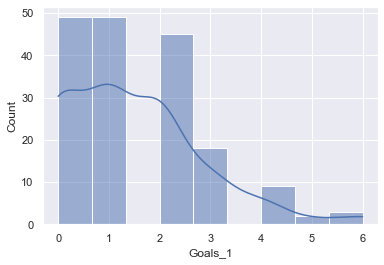


--------------------

Goals_2



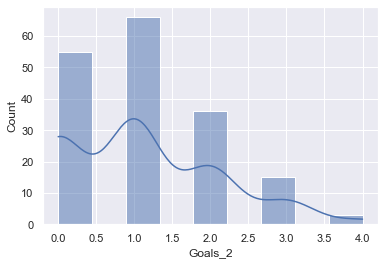


--------------------

Goal_diff



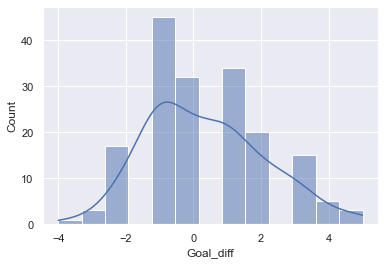


--------------------

Goal_total



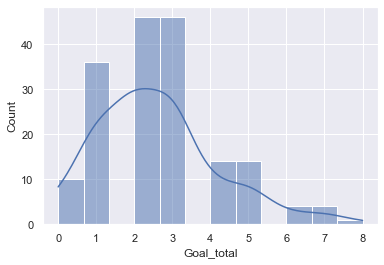


--------------------


In [3]:
def metric_histograms(df, metrics):
#     df = df_in.dropna(subset=[metric]).fillna("NULL")
    for metric in metrics:
        print("\n{0}\n".format(metric))
#         df[metric].hist()
        sns.histplot(data=df, x=metric, kde=True)
        plt.show()
#         sns.boxplot(x=df[metric])
#         plt.show()
        print("\n--------------------")

metric_histograms(match, ["Goals_1", "Goals_2", "Goal_diff", "Goal_total"])


Round

Group stage       132
Quarter-finals     20
Semi-finals        10
Round of 16         8
Final               5
Name: Round, dtype: int64


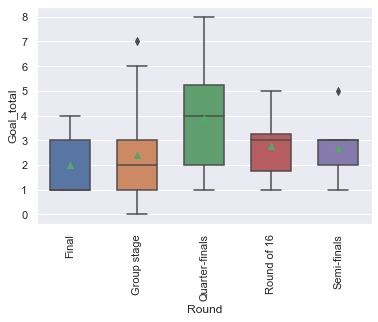


--------------------

Day

Sun    36
Sat    30
Wed    27
Mon    23
Tue    22
Thu    19
Fri    18
Name: Day, dtype: int64


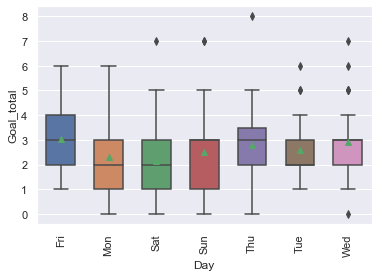


--------------------

Time

20:45 (19:45)    52
18:00 (17:00)    38
21:00 (20:00)    27
19:45            23
21:45 (19:45)    11
15:00 (14:00)     9
17:00             8
19:00 (17:00)     4
22:00 (20:00)     1
14:30 (13:30)     1
20:00 (19:00)     1
Name: Time, dtype: int64


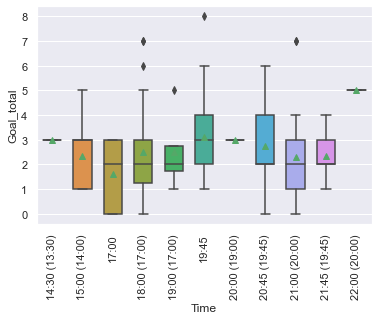


--------------------

Year

2016    51
2012    31
2008    31
2004    31
2000    31
Name: Year, dtype: int64


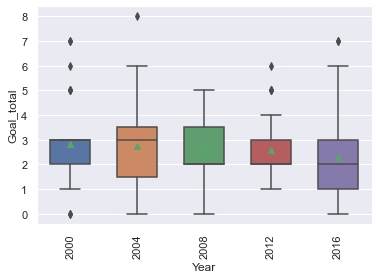


--------------------

Venue_country

NULL           47
France         45
Ukraine        16
Netherlands    16
Belgium        15
Austria        13
Switzerland    12
Poland         11
Name: Venue_country, dtype: int64


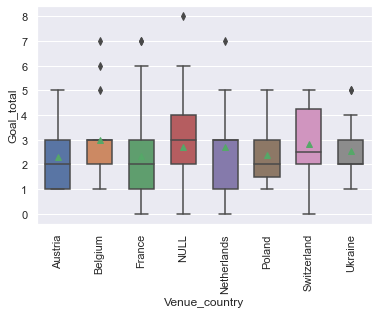


--------------------

Result

Win     77
Loss    66
Draw    32
Name: Result, dtype: int64


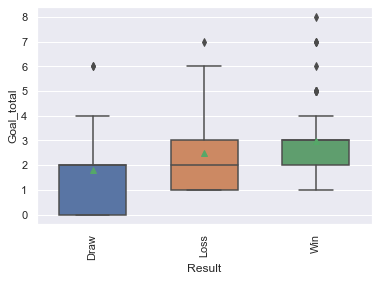


--------------------


In [4]:
def group_boxplots(df_in, cols, metric):
    df = df_in.dropna(subset=[metric]).fillna("NULL")
    for col in cols:
        print("\n{0}\n".format(col))
        print(df[col].value_counts())
        sns.boxplot(x=col, y=metric, data=df.sort_values(by=col), 
                    showmeans=True, width=0.6)
        plt.xticks(rotation=90)

    #     plt.savefig("../reports/figures/club_01_boxplot_{0}.PNG".format(col))
        plt.show()
        print("\n--------------------")
        
col_list = ["Round", "Day", "Time", "Year", "Venue_country", "Result"]

group_boxplots(match, col_list, "Goal_total")

In [5]:
summary = utilities.get_master("nations_summaries")
# summary.info()

summary = summary[['Rank Local', 'Rank Global', 'Team', 'Rating',
       'Average Rank', 'Average Rating', '1 Year Change Rank',
       '1 Year Change Rating', 'Matches Total', 'Matches Home', 'Matches Away',
       'Matches Neutral', 'Matches Wins', 'Matches Losses', 'Matches Draws',
       'Goals For', 'Goals Against', 'Year', 'Country',
       'Data Year', 'GDP (PPP)', 'Population']]

summary["GDP (PPP) Per Capita"] = summary['GDP (PPP)'] / summary['Population']

summary.describe(include="all").T

2021-05-28 17:52:56,602 - INFO - Building master filepath for nations_summaries
2021-05-28 17:52:56,603 - INFO - Fetching C:\Users\adeacon\Documents\GitHub\the-ball-is-round\data\processed\ftb_nations_summaries.txt
2021-05-28 17:52:56,604 - INFO - Building master filepath for nations_summaries


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank Local,112,NaN,NaN,NaN,10.1964,6.06398,1,5,10,14.25,24
Rank Global,112,NaN,NaN,NaN,18.6964,14.7769,1,8,15,26,74
Team,112,35,Czech Republic,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,112,NaN,NaN,NaN,1856,122.945,1524,1771.25,1853,1948.25,2127
Average Rank,112,NaN,NaN,NaN,22.5268,16.0921,4,11,19,27.25,83
Average Rating,112,NaN,NaN,NaN,1769.49,128.753,1390,1704.75,1785.5,1875.25,1985
1 Year Change Rank,112,NaN,NaN,NaN,1.41071,5.92073,-15,-2,1,4,23
1 Year Change Rating,112,NaN,NaN,NaN,7.26786,42.6667,-92,-24.25,7.5,35.25,127
Matches Total,112,NaN,NaN,NaN,638.009,214.417,63,537.25,659.5,787,1073
Matches Home,112,NaN,NaN,NaN,285.482,98.4145,23,223,295,360,467



Rating



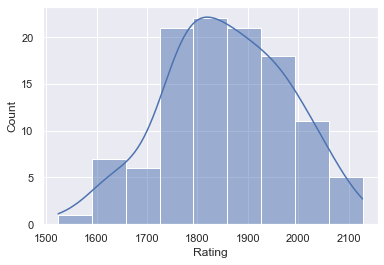


--------------------

Average Rank



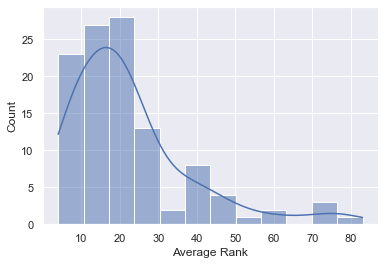


--------------------

Average Rating



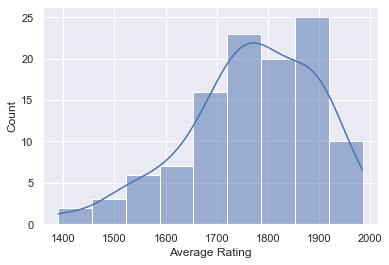


--------------------

1 Year Change Rank



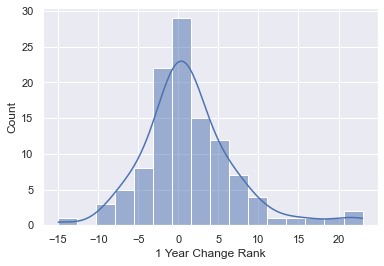


--------------------

1 Year Change Rating



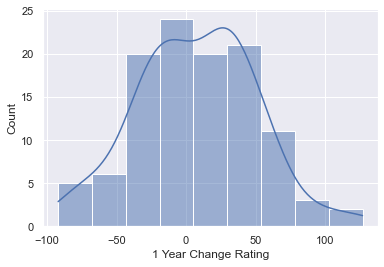


--------------------

Matches Total



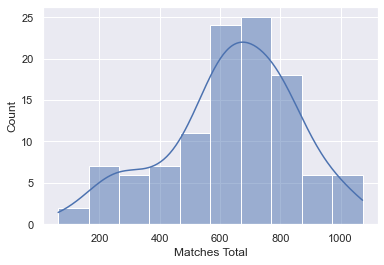


--------------------

Matches Home



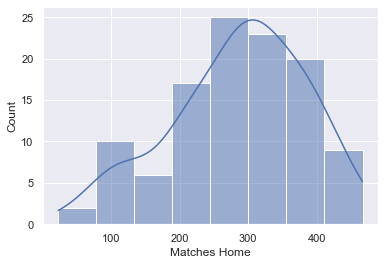


--------------------

Matches Away



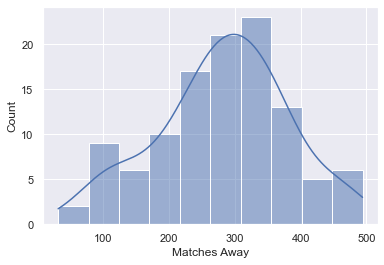


--------------------

Matches Neutral



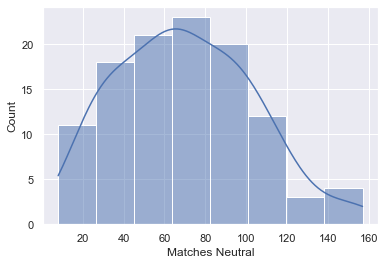


--------------------

Matches Wins



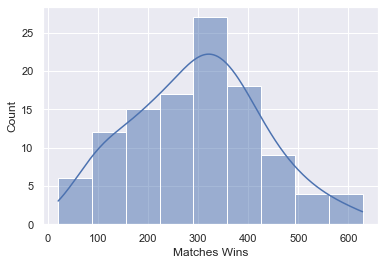


--------------------

Matches Losses



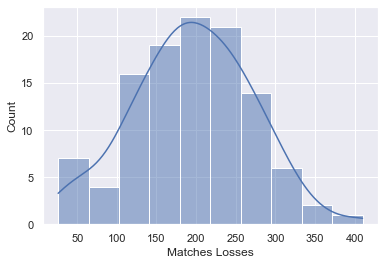


--------------------

Matches Draws



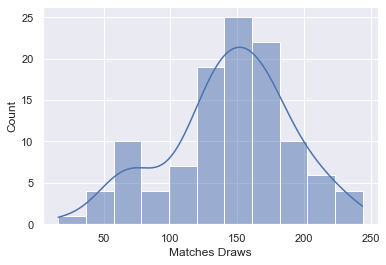


--------------------

Goals For



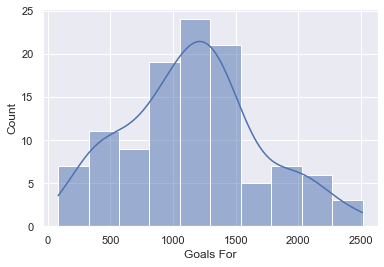


--------------------

Goals Against



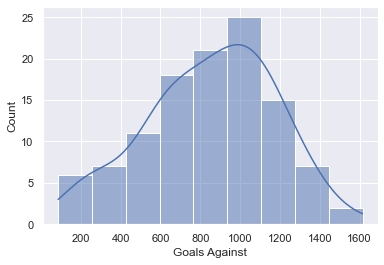


--------------------

GDP (PPP)



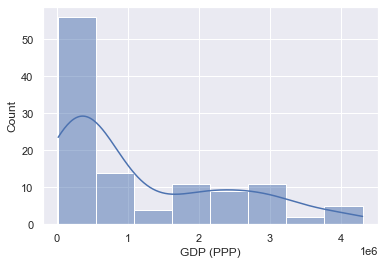


--------------------

Population



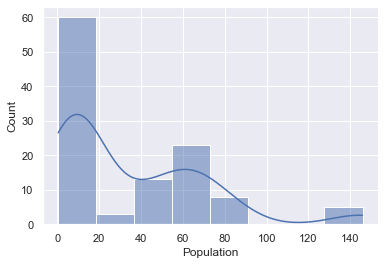


--------------------

GDP (PPP) Per Capita



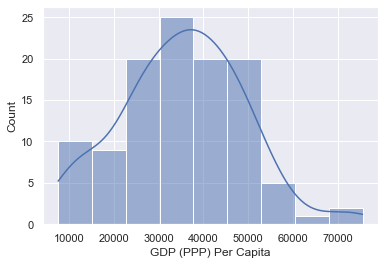


--------------------


In [6]:
metric_histograms(summary, ['Rating', 'Average Rank',
       'Average Rating', '1 Year Change Rank', '1 Year Change Rating',
       'Matches Total', 'Matches Home', 'Matches Away', 'Matches Neutral',
       'Matches Wins', 'Matches Losses', 'Matches Draws', 'Goals For',
       'Goals Against', 'GDP (PPP)',
       'Population', 'GDP (PPP) Per Capita'])

## 3. Data Preperation

* Select Data
* Clean Data
* Construct Data
* Integrate Data
* Format Data

In [7]:
## fix data mismatch

for col in ["Team_1", "Team_2"]:
    print("\n")
    print(match[~match[col].isin(summary.Team.values)][col].value_counts())
    print("\n")
    print(summary[~summary.Team.isin(match[col].values)].Team.value_counts())



England                10
Wales                   4
Republic of Ireland     2
Scotland                1
Northern Ireland        1
Name: Team_1, dtype: int64


England             5
Wales               2
Ireland             2
Northern Ireland    1
Scotland            1
Name: Team, dtype: int64


 England               8
Republic of Ireland    5
 Wales                 5
 Northern Ireland      3
 Scotland              2
Name: Team_2, dtype: int64


England             5
Wales               2
Ireland             2
Northern Ireland    1
Scotland            1
Name: Team, dtype: int64


In [8]:
data = match.merge(summary, left_on=["Team_1", "Year"], right_on=["Team", "Year"]) #, suffixes=["", "_1"])
data = data.merge(summary, left_on=["Team_2", "Year"], right_on=["Team", "Year"], suffixes=["", " (2)"])

data["Elo_rating_diff"] = data["Rating"] - data["Rating (2)"]
data["Home_advantage"] = data["Home_1"] - data["Home_2"]
# data["Win_expectency_1"] = ((10**((-(data.Elo_rating_diff + (100 * data.Home_advantage)))/400))+1)**-1
data["Relative_experience"] = data["Matches Total"] / data["Matches Total (2)"]
data["Relative_population"] = data["Population"] / data["Population (2)"]
data["Relative_GDP_per_capita"] = data["GDP (PPP) Per Capita"] / data["GDP (PPP) Per Capita (2)"]
data["Relative_ELO_rating"] = data["Rating"] / data["Rating (2)"]
# data["Relative_ELO_rank_1yr_change"] = data["1 Year Change Rank"] / data["1 Year Change Rank (2)"]
# data["Relative_ELO_rating_1yr_change"] = data["1 Year Change Rating"] / data["1 Year Change Rating (2)"]

# model_years = [2000, 2004, 2008, 2012, 2016]
live_years = [2021]
data["Usage"] = "Model"
data.loc[data.Year.isin(live_years), "Usage"] = "Live"

# data = data[["Date", "Year", "Team_1", "Team_2", "Goal_diff", "Goal_total", "Elo_rating_diff", "Home_advantage", "Win_expectency_1",
#              "Relative_experience", "Relative_population", "Relative_GDP_per_capita",
#             "Relative_ELO_rating"]] #, "Relative_ELO_rank_1yr_change", "Relative_ELO_rating_1yr_change"
# ]]

# data.columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,173.0,2.010358e+03,7.078374e+00,2000.000000,2004.000000,2012.000000,2.016000e+03,2.021000e+03
Goals_1,145.0,1.420690e+00,1.352308e+00,0.000000,0.000000,1.000000,2.000000e+00,6.000000e+00
Goals_2,145.0,1.110345e+00,9.726627e-01,0.000000,0.000000,1.000000,2.000000e+00,4.000000e+00
Goal_diff,145.0,3.103448e-01,1.757987e+00,-4.000000,-1.000000,0.000000,1.000000e+00,5.000000e+00
Home_1,173.0,1.329480e-01,3.405040e-01,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
Home_2,173.0,9.248555e-02,2.905511e-01,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
Goal_total,145.0,2.531034e+00,1.568152e+00,0.000000,1.000000,2.000000,3.000000e+00,7.000000e+00
Rank Local,173.0,9.202312e+00,5.880555e+00,1.000000,4.000000,9.000000,1.400000e+01,2.400000e+01
Rank Global,173.0,1.705202e+01,1.446980e+01,1.000000,6.000000,13.000000,2.300000e+01,7.400000e+01
Rating,173.0,1.872948e+03,1.255476e+02,1524.000000,1783.000000,1873.000000,1.972000e+03,2.127000e+03


In [9]:
data.corr().style.background_gradient(cmap='coolwarm')

In [10]:
# # Computing IQR
# Q1 = data.quantile(0.25)
# Q3 = data.quantile(0.75)
# IQR = Q3 - Q1

# # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
# lower_limit = Q1 - (1.5 * IQR)
# upper_limit = Q3 + (1.5 * IQR)

# lower_limit, upper_limit
# # data[(data < lower_limit) | (data > upper_limit)].dropna(how="all")

In [11]:
# data_lim = data.copy(deep=True)

# for col in data_lim.columns:
#     if col == "Home_advantage":
#         continue
#     data_lim.loc[data_lim[col] < lower_limit[col], col] = lower_limit[col]
#     data_lim.loc[data_lim[col] > upper_limit[col], col] = upper_limit[col]
    
# data_lim = pd.DataFrame(MinMaxScaler().fit_transform(data_lim), columns=data_lim.columns)
    
# data_lim.describe().T

In [12]:
# data_lim.corr().style.background_gradient(cmap='coolwarm')

In [13]:
# sns.pairplot(data_lim, size = 2.5)
# plt.show();

## 4. Modelling

* Select Modelling Technique
* Generate Test Design
* Build Model
* Assess Model

### Updated WC model
* https://github.com/deacona/the-ball-is-round/blob/master/reports/intl_01_world_cup_2018.md
* https://github.com/deacona/the-ball-is-round/blob/master/notebooks/intl_01_world_cup_2018.ipynb

### "Soccernomics"
* goal diff = (0.6666 * home adv) + (0.5 * relative experience) + (0.1 * relative population) + (0.1 * relative gdp/head) + ...
* e.g. England vs Germany at Euro 96
    * Home = England = 1
    * Exp = 84k v 84k = 0
    * Pop = 57 v 81 = -0.4
    * GDP/h = 1627492 / 57 v 2633828 / 81 = -0.1
    * GD = (0.6666 * 1) + (0.5 * 0) + (0.1 * -0.4) + (0.1 * -0.1) = 0.6
* http://www.soccernomics-agency.com/wordpress/wp-content/uploads/2017/10/soccer-convergence-1.pdf

### Dixon-Coles (and other probability models)
* https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling-dixon-coles-and-time-weighting/
* http://www.statsandsnakeoil.com/2018/06/05/modelling-the-world-cup-with-regista/
* http://opisthokonta.net/?cat=48

In [14]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
# from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import VotingRegressor
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
# from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

# np.random.seed(1)

In [15]:
gd_features = ["Home_advantage", "Relative_experience", "Relative_population", "Relative_GDP_per_capita"]
gt_features = ["Home_advantage", "Relative_experience", "Relative_population", "Relative_GDP_per_capita"]

gd_target = "Goal_diff"
gt_target = "Goal_total"

gd_X = data.loc[~data.Year.isin(live_years), gd_features]
gd_y = data.loc[~data.Year.isin(live_years), gd_target]
gt_X = data.loc[~data.Year.isin(live_years), gt_features]
gt_y = data.loc[~data.Year.isin(live_years), gt_target]

gd_X_train, gd_X_test, gd_y_train, gd_y_test = train_test_split(gd_X, gd_y, random_state=42, train_size=0.8)
gt_X_train, gt_X_test, gt_y_train, gt_y_test = train_test_split(gt_X, gt_y, random_state=42, train_size=0.8)

print("GD Train data has shape: {0}".format(gd_X_train.shape))
print("GD Test data has shape: {0}".format(gd_X_test.shape))
print("------")
print("GT Train data has shape: {0}".format(gt_X_train.shape))
print("GT Test data has shape: {0}".format(gt_X_test.shape))

GD Train data has shape: (116, 4)
GD Test data has shape: (29, 4)
------
GT Train data has shape: (116, 4)
GT Test data has shape: (29, 4)


In [16]:
# model = LinearRegression(fit_intercept=False, normalize=True)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# {"MedAE": median_absolute_error(y_test, y_pred),
#             "RMSE": mean_squared_error(y_test, y_pred, squared=False),
#             "R^2": r2_score(y_test, y_pred),
#            }

In [17]:
# params = pd.Series(model.coef_, index=X_train.columns)
# # params
# err = np.std([model.fit(*resample(X_train, y_train)).coef_ for i in range(1000)], 0)

# pd.DataFrame({"effect": params.round(2), "error": err.round(2)})

In [18]:
%%time

## add ELO model?

def model_pipe(model, X_train, y_train):
    """
    INPUT:
        model: Untrained regression model
        X_train: Training features
        y_train: Training target
        
    OUTPUT:
        model: Trained model
    """
    
#     model = TransformedTargetRegressor(regressor=model, transformer=MinMaxScaler())
    model = Pipeline(steps=[('standardizer', StandardScaler()),
#                             ('normalizer', MinMaxScaler()),
                      ('estimator', model)])
    model.fit(X_train, y_train)
    
    return model

def get_trained_models(X_train, y_train):
    """
    INPUT:
        X_train: Training features
        y_train: Training target
        
    OUTPUT:
        model_list: List of trained models
    """
    model_list = [
        {"Name": "Dummy (mean)", "Reg": model_pipe(DummyRegressor(strategy="mean"), X_train, y_train)},
        {"Name": "Dummy (median)", "Reg": model_pipe(DummyRegressor(strategy="median"), X_train, y_train)},
        {"Name": "Linear Reg", "Reg": model_pipe(LinearRegression(), X_train, y_train)}, #sometimes skews results table
        {"Name": "Lasso", "Reg": model_pipe(Lasso(), X_train, y_train)},
        {"Name": "Ridge", "Reg": model_pipe(Ridge(), X_train, y_train)},
    #     {"Name": "Bayesian Ridge", "Reg": model_pipe(BayesianRidge(), X_train, y_train)},
        {"Name": "Random Forest", "Reg": model_pipe(RandomForestRegressor(random_state=42), X_train, y_train)},
    #     {"Name": "Random Forest (tuned)", "Reg": rf_tuned(X_train, y_train)},
        {"Name": "Gradient Boost", "Reg": model_pipe(GradientBoostingRegressor(), X_train, y_train)},
    #     {"Name": "K Neighbors", "Reg": model_pipe(KNeighborsRegressor(), X_train, y_train)},
        {"Name": "SVM (linear)", "Reg": model_pipe(SVR(kernel="linear"), X_train, y_train)},
        {"Name": "SVM (rbf)", "Reg": model_pipe(SVR(kernel="rbf"), X_train, y_train)},
    #     {"Name": "Voting (RF+KNN)", "Reg": model_pipe(VotingRegressor([('rf', RandomForestRegressor(random_state=42)), 
    #                                                             ('knn', KNeighborsRegressor())]), X_train, y_train)},
    #     {"Name": "Voting (LR+RF+KNN)", "Reg": model_pipe(VotingRegressor([('lr', LinearRegression()),
    #                                                             ('rf', RandomForestRegressor(random_state=42)),
    #                                                             ('knn', KNeighborsRegressor())]), X_train, y_train)},
    ]

    return model_list

gd_model_list = get_trained_models(gd_X_train, gd_y_train)
gt_model_list = get_trained_models(gt_X_train, gt_y_train)

len(gd_model_list), len(gt_model_list)

Wall time: 354 ms


(9, 9)

## 5. Evaluation

* Evaluate Results
* Review Process
* Determine Next Steps

```
# % correct score, goal diff, result, points
# vs historic trends (goals, W/D/L)
```

Goal difference model

Evaluating Dummy (mean)...

{'MedAE': 1.7672413793103448, 'RMSE': 2.126935713445986, 'R^2': -0.03441068515497525, 'Name': 'Dummy (mean)'}


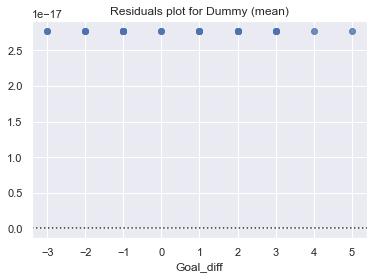


--------------------

Evaluating Dummy (median)...

{'MedAE': 2.0, 'RMSE': 2.181426297094443, 'R^2': -0.0880913539967374, 'Name': 'Dummy (median)'}


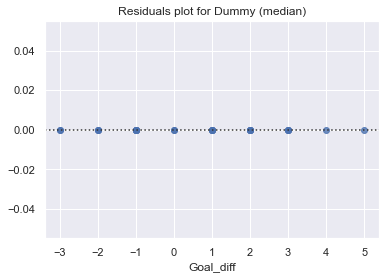


--------------------

Evaluating Linear Reg...

{'MedAE': 1.3408721774714916, 'RMSE': 2.1069949071529743, 'R^2': -0.015105644400317697, 'Name': 'Linear Reg'}


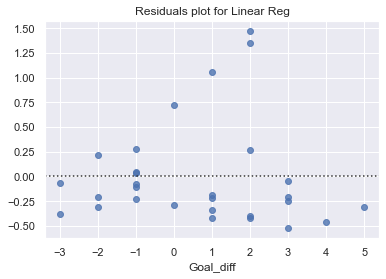


--------------------

Evaluating Lasso...

{'MedAE': 1.7672413793103448, 'RMSE': 2.126935713445986, 'R^2': -0.03441068515497525, 'Name': 'Lasso'}


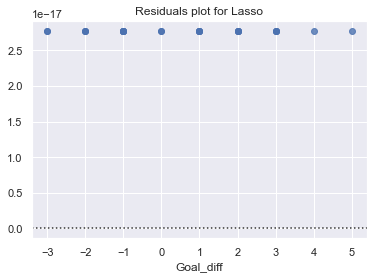


--------------------

Evaluating Ridge...

{'MedAE': 1.3456764737303994, 'RMSE': 2.1067469028217567, 'R^2': -0.014866691966765488, 'Name': 'Ridge'}


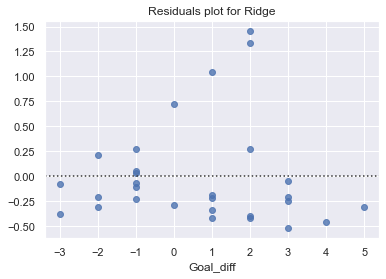


--------------------

Evaluating Random Forest...

{'MedAE': 2.05, 'RMSE': 2.341004058091314, 'R^2': -0.25310829255029876, 'Name': 'Random Forest'}


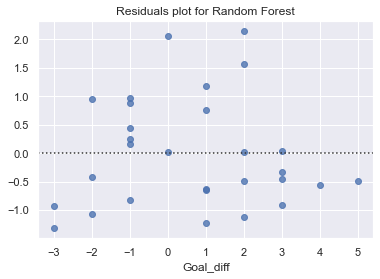


--------------------

Evaluating Gradient Boost...

{'MedAE': 1.9483445480740613, 'RMSE': 2.374543520921922, 'R^2': -0.2892719631442813, 'Name': 'Gradient Boost'}


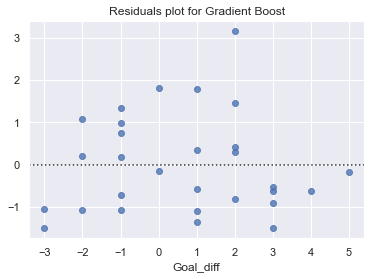


--------------------

Evaluating SVM (linear)...

{'MedAE': 1.5054012420818588, 'RMSE': 2.1560661787620234, 'R^2': -0.06293925226113095, 'Name': 'SVM (linear)'}


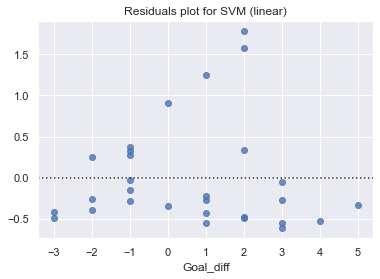


--------------------

Evaluating SVM (rbf)...

{'MedAE': 1.5770912891176907, 'RMSE': 2.3009319170660696, 'R^2': -0.21057529764670413, 'Name': 'SVM (rbf)'}


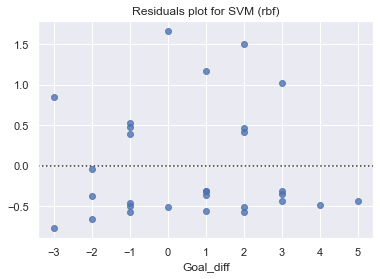


--------------------

9 models evaluated
Goal total model

Evaluating Dummy (mean)...

{'MedAE': 0.5948275862068964, 'RMSE': 1.3739388944244812, 'R^2': -0.0569657123834888, 'Name': 'Dummy (mean)'}


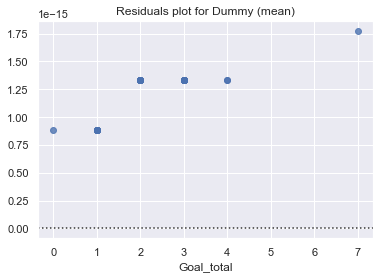


--------------------

Evaluating Dummy (median)...

{'MedAE': 1.0, 'RMSE': 1.364576478442026, 'R^2': -0.04260985352862878, 'Name': 'Dummy (median)'}


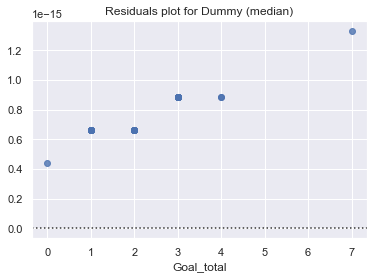


--------------------

Evaluating Linear Reg...

{'MedAE': 0.8280960396830523, 'RMSE': 1.5078586652816524, 'R^2': -0.2730554936784533, 'Name': 'Linear Reg'}


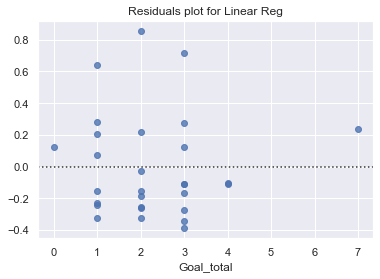


--------------------

Evaluating Lasso...

{'MedAE': 0.5948275862068964, 'RMSE': 1.3739388944244812, 'R^2': -0.0569657123834888, 'Name': 'Lasso'}


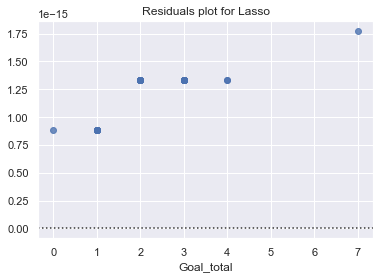


--------------------

Evaluating Ridge...

{'MedAE': 0.8265290359807271, 'RMSE': 1.50686684320468, 'R^2': -0.2713812926290584, 'Name': 'Ridge'}


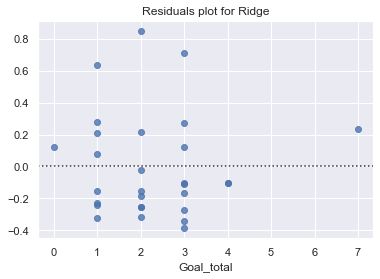


--------------------

Evaluating Random Forest...

{'MedAE': 1.0350000000000001, 'RMSE': 1.5069537273580988, 'R^2': -0.27152790952803696, 'Name': 'Random Forest'}


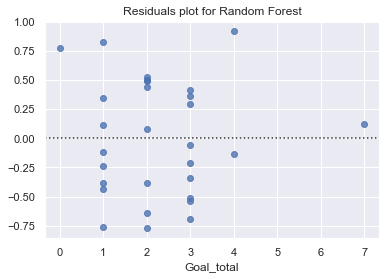


--------------------

Evaluating Gradient Boost...

{'MedAE': 1.2533755838600227, 'RMSE': 1.5987162422889896, 'R^2': -0.431096229856595, 'Name': 'Gradient Boost'}


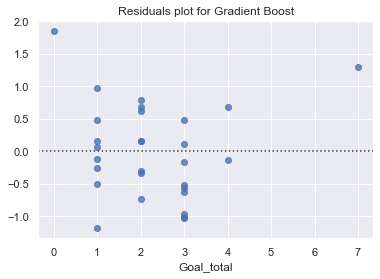


--------------------

Evaluating SVM (linear)...

{'MedAE': 1.001224233463077, 'RMSE': 1.4610249166757023, 'R^2': -0.1952019918847081, 'Name': 'SVM (linear)'}


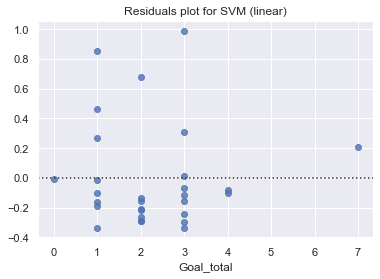


--------------------

Evaluating SVM (rbf)...

{'MedAE': 0.8934104387017276, 'RMSE': 1.4251456278222854, 'R^2': -0.1372201670315054, 'Name': 'SVM (rbf)'}


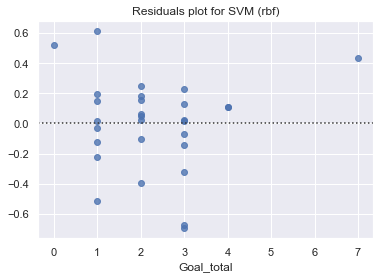


--------------------

9 models evaluated


In [19]:
def get_model_scores(y_act, y_pred):
    """
    INPUT:
        y_act - Actual values from target vector
        y_pred - Predicted values from target vector
        
    OUTPUT:
        Dictionary containing multiple scoring metrics with nice labels as keys
    """
    
    return {"MedAE": median_absolute_error(y_act, y_pred),
            "RMSE": mean_squared_error(y_act, y_pred, squared=False),
            "R^2": r2_score(y_act, y_pred),
           }

def evaluate_models(model_list, X_test, y_test, show_plots=True):
    """
    INPUT:
        y_act - Actual values from target vector
        y_pred - Predicted values from target vector
        show_plots: True/False to display any plots
        
    OUTPUT:
        Dictionary containing multiple scoring metrics with nice labels as keys
    """

    eval_list = []
    for model in model_list:
        print("\nEvaluating {0}...\n".format(model["Name"]))

        y_pred = model["Reg"].predict(X_test)
        eval_dict = get_model_scores(y_test, y_pred)
        eval_dict["Name"] = model["Name"]
        print(eval_dict)
        eval_list.append(eval_dict)

        if show_plots:
    #         residuals = y_test - y_pred
        #     plt.scatter(residuals,y_pred)
            sns.residplot(x=y_test, y=y_pred)
        #     sns.regplot(x=y_test, y=residuals, ci=99)
            plt.title("Residuals plot for {0}".format(model["Name"]))
            plt.show()

        #     plt.hist(residuals, bins=20)
        # #     plt.xlim(-40,50)
        #     plt.xlabel('Residuals')
        #     plt.title("Residuals histogram for {0}".format(model["Name"]))
        #     plt.show()

        print("\n--------------------")

    print("\n{0} models evaluated".format(len(eval_list)))

    eval_df = pd.DataFrame(eval_list)
    # eval_df.columns

    return eval_df

show_eval_plots = True

print("Goal difference model")
gd_eval = evaluate_models(gd_model_list, gd_X_test, gd_y_test, show_plots=show_eval_plots)
print("==============")
print("==============")
print("Goal total model")
gt_eval = evaluate_models(gt_model_list, gt_X_test, gt_y_test, show_plots=show_eval_plots)

In [20]:
gd_eval[['Name', 'R^2', 'RMSE', 'MedAE']]\
        .style\
        .background_gradient(cmap='Reds', subset=['RMSE', 'MedAE'])\
        .background_gradient(cmap='Greens', subset=['R^2'])

,Name,R^2,RMSE,MedAE
0,Dummy (mean),-0.034411,2.126936,1.767241
1,Dummy (median),-0.088091,2.181426,2.000000
2,Linear Reg,-0.015106,2.106995,1.340872
3,Lasso,-0.034411,2.126936,1.767241
4,Ridge,-0.014867,2.106747,1.345676
5,Random Forest,-0.253108,2.341004,2.050000
6,Gradient Boost,-0.289272,2.374544,1.948345
7,SVM (linear),-0.062939,2.156066,1.505401
8,SVM (rbf),-0.210575,2.300932,1.577091


In [21]:
gt_eval[['Name', 'R^2', 'RMSE', 'MedAE']]\
        .style\
        .background_gradient(cmap='Reds', subset=['RMSE', 'MedAE'])\
        .background_gradient(cmap='Greens', subset=['R^2'])

,Name,R^2,RMSE,MedAE
0,Dummy (mean),-0.056966,1.373939,0.594828
1,Dummy (median),-0.042610,1.364576,1.000000
2,Linear Reg,-0.273055,1.507859,0.828096
3,Lasso,-0.056966,1.373939,0.594828
4,Ridge,-0.271381,1.506867,0.826529
5,Random Forest,-0.271528,1.506954,1.035000
6,Gradient Boost,-0.431096,1.598716,1.253376
7,SVM (linear),-0.195202,1.461025,1.001224
8,SVM (rbf),-0.137220,1.425146,0.893410


In [22]:
# kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# # Create CV training and test scores for various training set sizes
# train_sizes, train_scores, test_scores = learning_curve(model_list[2]["Reg"], 
#                                                         X_train, 
#                                                         y_train,
#                                                         cv=kfold,
#                                                         # 50 different sizes of the training set
#                                                         train_sizes=np.linspace(0.1, 1.0, 50))

# # Create means and standard deviations of training set scores
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)

# # Create means and standard deviations of test set scores
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# # Draw lines
# plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
# plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# # Draw bands
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# # Create plot
# plt.title("Learning curve")
# plt.xlabel("Training set size"), plt.ylabel("R^2 score"), plt.legend(loc="best")
# plt.tight_layout()
# plt.show()

In [23]:
selected_gd_model = gd_model_list[2]["Reg"]
selected_gt_model = gt_model_list[3]["Reg"]

selected_gd_model, selected_gt_model

(Pipeline(steps=[('standardizer', StandardScaler()),
                 ('estimator', LinearRegression())]),
 Pipeline(steps=[('standardizer', StandardScaler()), ('estimator', Lasso())]))

## 6. Deployment

* Plan Deployment
* Plan Monitoring and Maintenance
* Produce Final Report
* Review Project

In [24]:
output = data.copy(deep=True)[["Date", "Year", "Team_1", "Team_2", "Usage", "Goals_1", "Goals_2", "Goal_diff", "Goal_total", "Result"]]
output.columns = ["Date", "Year", "Team_1", "Team_2", "Usage", "Actual_score_1", "Actual_score_2", "Actual_goal_diff", "Actual_goal_total", "Actual_result"]

gd_pred = selected_gd_model.predict(data[gd_features])
gt_pred = selected_gt_model.predict(data[gt_features])


## add weights?
output["Predicted_score_1"] = ((gt_pred + gd_pred) / 2).round()
output["Predicted_score_2"] = ((gt_pred - gd_pred) / 2).round()
output["Predicted_goal_diff"] = output.Predicted_score_1 - output.Predicted_score_2
output["Predicted_goal_total"] = output.Predicted_score_1 + output.Predicted_score_2
output["Predicted_result"] = None
output.loc[output.Predicted_score_1 == output.Predicted_score_2, "Predicted_result"] = "Draw"
output.loc[output.Predicted_score_1 > output.Predicted_score_2, "Predicted_result"] = "Win"
output.loc[output.Predicted_score_1 < output.Predicted_score_2, "Predicted_result"] = "Loss"

output["Correct_result"] = (output.Actual_result == output.Predicted_result).astype(int)
output["Correct_goal_diff"] = (output.Actual_goal_diff == output.Predicted_goal_diff).astype(int)
output["Correct_score"] = ((output.Actual_score_1 == output.Predicted_score_1) & (output.Actual_score_2 == output.Predicted_score_2)).astype(int)
output["Points"] = output.Correct_result + output.Correct_goal_diff + output.Correct_score

for col in ["Correct_result", "Correct_goal_diff", "Correct_score", "Points"]:
    output.loc[pd.isnull(output.Actual_result), col] = np.nan

output.to_csv("../data/interim/intl_02_predictions.csv", index=False)
output.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,173,104,2021-06-21,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,173,NaN,NaN,NaN,2010.36,7.07837,2000,2004,2012,2016,2021
Team_1,173,30,Germany,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team_2,173,30,France,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Usage,173,2,Model,145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actual_score_1,145,NaN,NaN,NaN,1.42069,1.35231,0,0,1,2,6
Actual_score_2,145,NaN,NaN,NaN,1.11034,0.972663,0,0,1,2,4
Actual_goal_diff,145,NaN,NaN,NaN,0.310345,1.75799,-4,-1,0,1,5
Actual_goal_total,145,NaN,NaN,NaN,2.53103,1.56815,0,1,2,3,7
Actual_result,145,3,Win,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
summary = pd.concat([
    output[pd.notnull(output.Actual_result)].Year.value_counts().sort_index(),
    output[pd.notnull(output.Actual_result)].groupby("Year")[["Points", "Correct_result", "Correct_goal_diff", "Correct_score",
                                                              "Predicted_goal_total", "Actual_goal_total"]].mean(),
    output[pd.notnull(output.Actual_result) & (output.Predicted_result != "Draw")].Year.value_counts() / output[pd.notnull(output.Actual_result)].Year.value_counts(),
    output[pd.notnull(output.Actual_result) & (output.Actual_result != "Draw")].Year.value_counts() / output[pd.notnull(output.Actual_result)].Year.value_counts(),
], axis=1)

summary.columns = ["Matches played", "Points per game", "% correct result", "% correct goal diff", "% correct score",
                   "Goals per game", "Goals per game (actual)", "% games won", "% games won (actual)"]

overall = pd.DataFrame({
    "Matches played": output[pd.notnull(output.Actual_result)].shape[0],
    "Points per game": output[pd.notnull(output.Actual_result)].Points.mean(),
    "% correct result": output[pd.notnull(output.Actual_result)].Correct_result.mean(),
    "% correct goal diff": output[pd.notnull(output.Actual_result)].Correct_goal_diff.mean(),
    "% correct score": output[pd.notnull(output.Actual_result)].Correct_score.mean(),
    "Goals per game": output[pd.notnull(output.Actual_result)].Predicted_goal_total.mean(),
    "Goals per game (actual)": output[pd.notnull(output.Actual_result)].Actual_goal_total.mean(),
    "% games won": output[pd.notnull(output.Actual_result) & (output.Predicted_result != "Draw")].shape[0] / output[pd.notnull(output.Actual_result)].shape[0],
    "% games won (actual)": output[pd.notnull(output.Actual_result) & (output.Actual_result != "Draw")].shape[0] / output[pd.notnull(output.Actual_result)].shape[0],
}, index=["Overall"])
summary = pd.concat([summary, overall], axis=0)

summary = summary.round(2)
pct_cols = ["% correct result", "% correct goal diff", "% correct score", "% games won", "% games won (actual)"]
summary[pct_cols] = (100 * summary[pct_cols]).astype(int).astype(str) + "%"
summary

,Matches played,Points per game,% correct result,% correct goal diff,% correct score,Goals per game,Goals per game (actual),% games won,% games won (actual)
2000,28,0.21,11%,7%,4%,2.07,2.75,21%,86%
2004,27,0.89,41%,33%,15%,2.26,2.41,26%,70%
2008,31,0.35,23%,10%,3%,2.29,2.61,28%,87%
2012,24,0.42,17%,12%,12%,2.12,2.50,12%,83%
2016,35,0.60,26%,23%,11%,2.20,2.40,26%,77%
Overall,145,0.50,23%,17%,9%,2.19,2.53,23%,81%
